# 变分自编码VAE

## 导入有关函数

In [1]:
import os
import numpy as np
import  matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torchvision.utils import save_image
from tqdm import tqdm

In [2]:
# 设备配置
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [3]:
# 如果没有文件夹就创建一个文件夹
sample_dir = 'vae_images'
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

In [4]:
# 超参数设置
image_size = 784
h_dim = 400
z_dim = 20
num_epochs = 20
batch_size = 32
learning_rate = 1e-3

## 数据集

In [5]:
dataset = torchvision.datasets.MNIST(root=os.path.join('data','MNIST'),
                                     train=True,
                                     transform=transforms.ToTensor(),
                                     download=True)  

# 数据加载器
data_loader = torch.utils.data.DataLoader(dataset=dataset,
                                          batch_size=batch_size, 
                                          shuffle=True,
                                         drop_last=True)

In [6]:
img,label = next(iter(data_loader))
img.shape,label.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

## 创建VAE模型

In [7]:
# VAE model
class VAE(nn.Module):
    def __init__(self, image_size=784, h_dim=400, z_dim=20):
        super(VAE, self).__init__()
        self.fc1 = nn.Linear(image_size, h_dim)
        self.fc2 = nn.Linear(h_dim, z_dim) # 均值 向量
        self.fc3 = nn.Linear(h_dim, z_dim) # log(方差) 向量
        self.fc4 = nn.Linear(z_dim, h_dim)
        self.fc5 = nn.Linear(h_dim, image_size)
        
    # 编码过程
    def encode(self, x):
        h = F.relu(self.fc1(x))
        mu = self.fc2(h)
        log_var = self.fc3(h)
        return mu,log_var

    # 解码过程
    def decode(self, z):
        h = F.relu(self.fc4(z))
        return torch.sigmoid(self.fc5(h))
    
    
    # 随机生成隐含向量
    def reparameterize(self, mu, log_var):
        std = torch.exp(log_var/2)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    # 整个前向传播过程：编码 -> 解码
    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        x_reconst = self.decode(z)
        return x_reconst, mu, log_var

## 训练

In [8]:
# 实例化一个模型
model = VAE().to(device)

In [9]:
# 创建优化器
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [ ]:
losses = []
outs,x_concats = [],[]
for epoch in range(num_epochs):
    loss_epoch = 0
    for i, (x, _) in enumerate(data_loader):
        # 获取样本，并前向传播
        x = x.to(device).view(-1, image_size)
        x_reconst, mu, log_var = model(x)
        
        
        # 计算对数似然函数和KL散度
        reconst_loss = 0.5*(x_reconst-x).pow(2).sum()      # 正态损失
#         reconst_loss = -torch.sum(x*(x_reconst).log()+(1-x)*(1-x_reconst).log()) 
        # reconst_loss = F.binary_cross_entropy(x_reconst, x, size_average=False) 
        kl_div = -0.5 * (1+log_var - mu.pow(2) - log_var.exp()).sum()
        loss = reconst_loss + kl_div
        loss_epoch += loss.item()
        
        
        # 反向传播和优化
        optimizer.zero_grad()  # 参数梯度设置为0
        loss.backward()        # 计算参数的梯度
        optimizer.step()       # 更新参数
          
        
        if (i+1) % 100 == 0: 
            losses.append([reconst_loss.item(), kl_div.item()])

    print(epoch,loss_epoch)
    # 利用训练的模型进行测试
    with torch.no_grad():
        # 随机生成的图像
        z = torch.randn(20, z_dim).to(device)
        out = model.decode(z).view(-1, 1, 28, 28)
        save_image(out,
                   os.path.join(sample_dir, 'sample-{}.png'.format(epoch+1)),
                   nrow = 4)

        # 重构的图像
        x_part = x[:20]
        out, _, _ = model(x_part)
        x_concat = torch.cat([x_part.view(-1, 1, 28, 28), out.view(-1, 1, 28, 28)], dim=3)
        save_image(out.view(-1, 1, 28, 28),
                   os.path.join(sample_dir, 'reconst-{}.png'.format(epoch+1)),
                   nrow = 4)

0 1755033.86328125
1 1415836.1510620117
2 1357125.6746826172
3 1318292.219543457
4 1290762.8973999023
5 1271674.1740722656
6 1257413.5634765625
7 1243656.655822754
8 1234759.3365478516
9 1226446.2692871094
10 1220028.3908691406
11 1213766.872619629
12 1209661.2331542969
13 1205449.91015625
14 1202638.031616211
15 1199801.965637207
16 1194868.9035644531
17 1192598.2251586914
18 1190276.127319336
19 1188303.6193847656


## 结果分析

### 误差

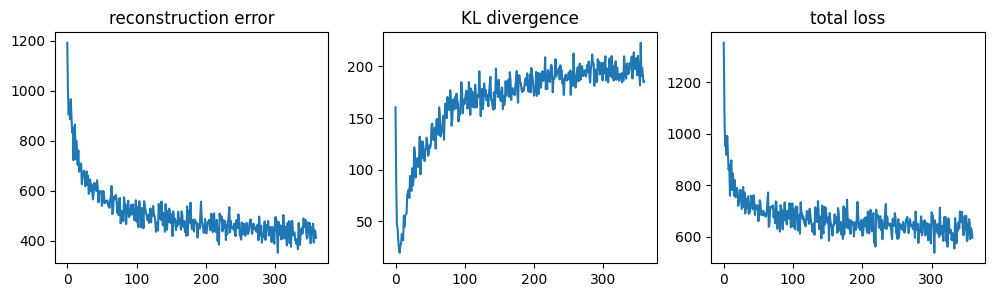

In [ ]:
# 误差
fig,ax = plt.subplots(1,3,figsize = (12,3))
_ = ax[0].plot(np.array(losses)[:,0]),ax[0].set_title('reconstruction error')
_ = ax[1].plot(np.array(losses)[:,1]),ax[1].set_title('KL divergence')
_ = ax[2].plot(np.array(losses).sum(axis=1)),ax[2].set_title('total loss')
_ = plt.show()

### 生成图像和重构图像

In [ ]:
# 使用png图片制作动画
import imageio
gif_images = []
for d in range(1,21):
    file = f"vae_images/sample-{d}.png"
    gif_images.append(imageio.imread(file))   # 读取图片
imageio.mimsave("vae-samples.gif", gif_images, fps=1)   # 转化为gif动画

/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  


In [ ]:
# 使用png图片制作动画
import imageio
gif_images = []
for d in range(1,21):
    file = f"vae_images/reconst-{d}.png"
    gif_images.append(imageio.imread(file))   # 读取图片
imageio.mimsave("vae-reconst.gif", gif_images, fps=1)   # 转化为gif动画

/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  


### 隐空间流行分析

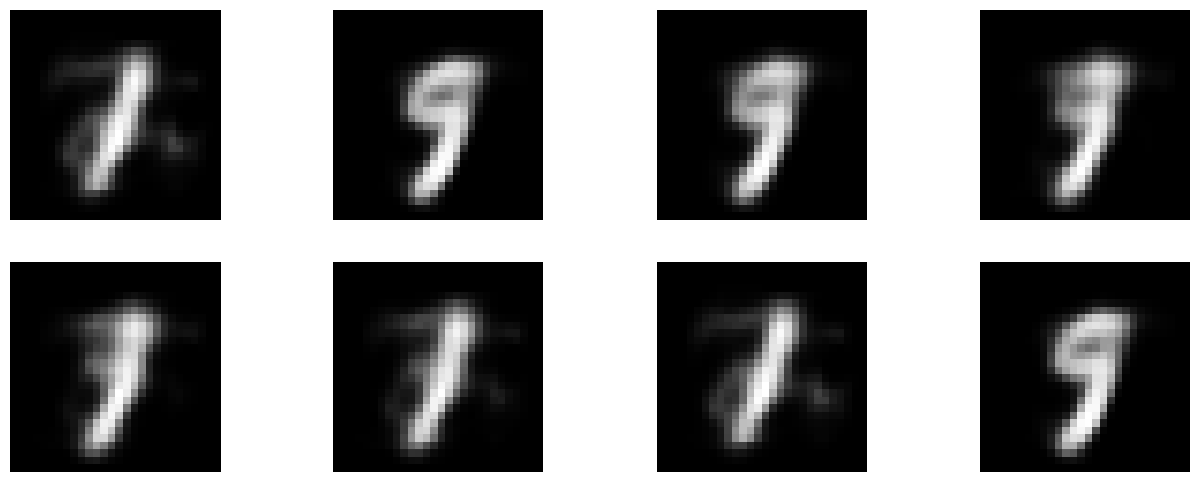

In [20]:
with torch.no_grad():
    # 在z空间插值，得到相应的图像
    z1 = torch.randn(1, z_dim).to(device)
    out1 = model.decode(z1).view(28, 28)

    z2 = torch.randn(1, z_dim).to(device)
    out2 = model.decode(z2).view(28, 28)

    outs = [out1]
    for a in np.linspace(0,1,6):
        z = a*z1+(1-a)*z2
        out =  model.decode(z).view(28, 28)
        outs.append(out)
    outs.append(out2)
    
    # 画图
    fig,ax = plt.subplots(2,len(outs)//2,figsize=(16,6))
    ax = ax.flatten()
    for i in range(len(outs)):
        _ = ax[i].imshow(outs[i].cpu(),'gray')
        _ = ax[i].axis('off')
plt.show()

# 问题